In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/initialization')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations/fc_abc.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import torch

from utils.tools import read_yaml, set_random_seeds
from utils.plot.abc_parameterizations.initializations import *
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected import ntk, ip, muP

### Load basic configuration and define variables 

In [5]:
L = 5
SEED = 42

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

config_dict['architecture']['n_layers'] = L + 1
base_model_config = ModelConfig(config_dict)

In [6]:
n_trials = 200
widths = [25, 50, 128, 256, 512, 750, 1024, 1200, 1400]
x = 2 * torch.rand(base_model_config.architecture["input_size"], requires_grad=False) - 1

# 1. With ReLU

## NTK 

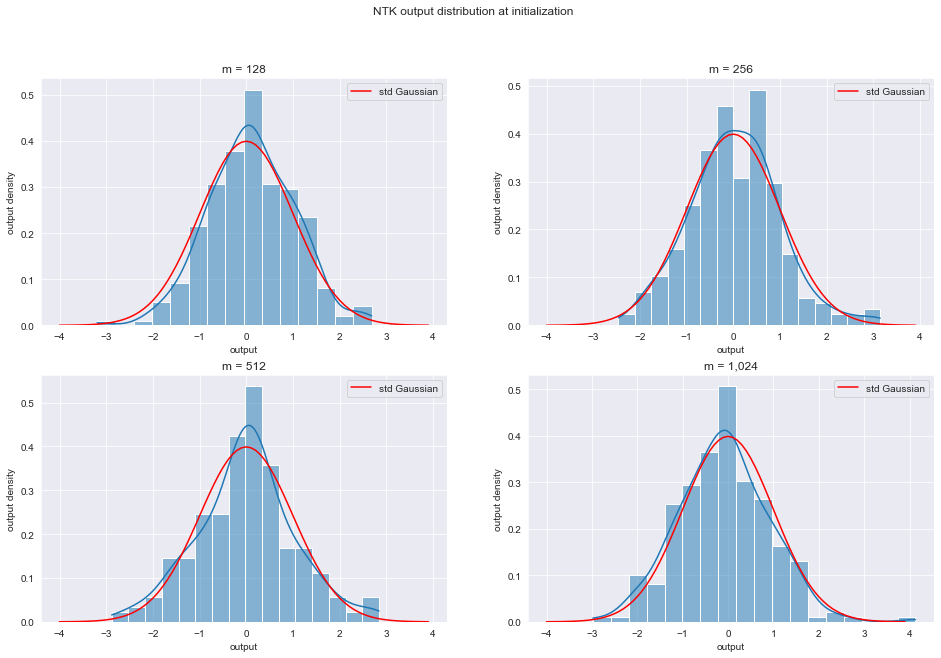

In [7]:
ntk_n_trials = 250
ntk_widths = [128, 256, 512, 1024]
fig_path = os.path.join(FIGURES_DIR, 'ntk_outputs_dist_L={}.png'.format(L))
plot_init_outputs_dist(fig_path, 'NTK', ntk.FCNTK, ntk_n_trials, ntk_widths, base_model_config, x=x, 
                       figsize=(16,10))

### muP

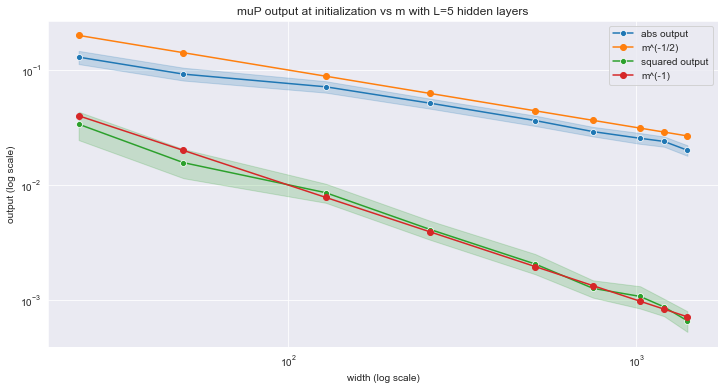

In [8]:
fig_path = os.path.join(FIGURES_DIR, 'muP_outputs_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'muP', muP.FCmuP, n_trials, widths, base_model_config, x=x)

### IP

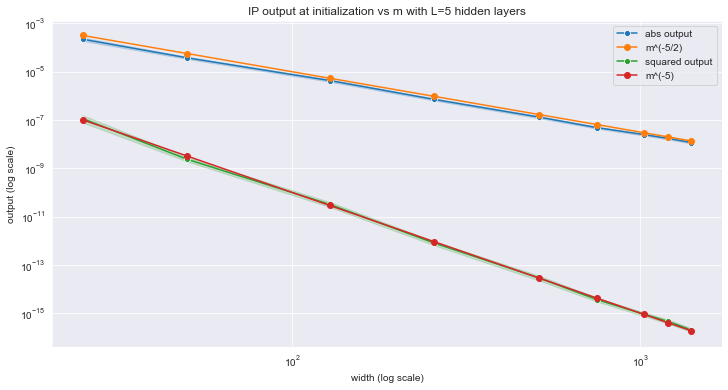

In [9]:
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP', ip.FCIP, n_trials, widths, base_model_config, x=x, c=0.)

# 2. With GeLU

### var = 2

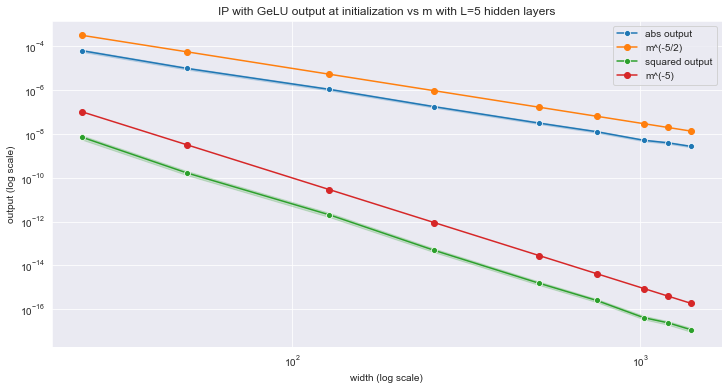

In [10]:
# default value for variance is 2.0
config = deepcopy(base_model_config)
config.activation.name = "gelu"
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_gelu_var_2_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP with GeLU', ip.FCIP, n_trials, widths, config, x=x, 
                                    c=0.)

### var = 4

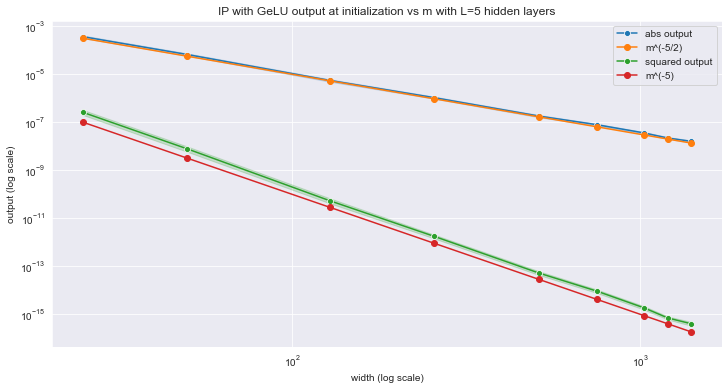

In [11]:
var = 4.0
config = deepcopy(base_model_config)
config.activation.name = "gelu"
config.initializer.params["var"] = var
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_gelu_var_4_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP with GeLU', ip.FCIP, n_trials, widths, config, x=x, 
                                    c=0.)

# 3. With ELU

### var = 2

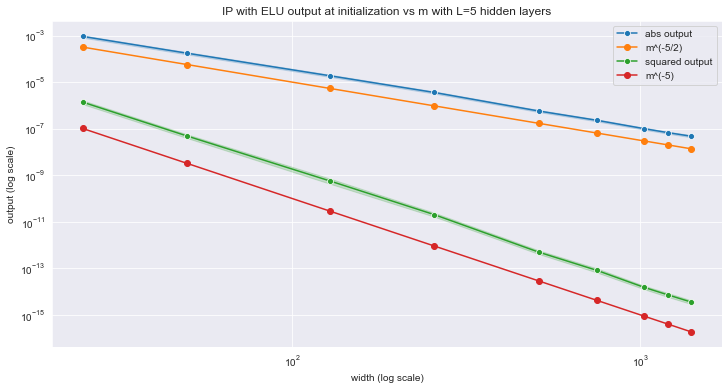

In [12]:
# default value for variance is 2.0
config = deepcopy(base_model_config)
config.activation.name = "elu"
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_elu_var_2_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP with ELU', ip.FCIP, n_trials, widths, config, x=x, 
                                    c=0.)

### var = 1

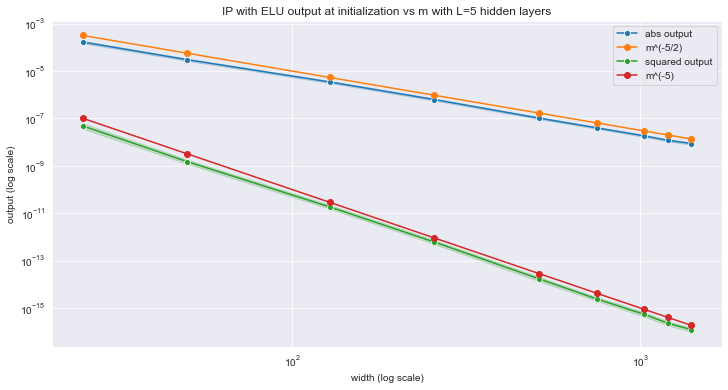

In [13]:
var = 1.0
config = deepcopy(base_model_config)
config.activation.name = "elu"
config.initializer.params["var"] = var
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_elu_var_1_L={}.png'.format(L))
results_df = plot_init_outputs_vs_m(fig_path, 'IP with ELU', ip.FCIP, n_trials, widths, config, x=x, 
                                    c=0.)

In [14]:
import pickle
from utils.tools import load_pickle

In [15]:
exp_path = os.path.join(ROOT, 'experiments', 'standard_fc_ip_mnist/L=4_m=256',
                        'activation=gelu_lr=0.001_batchsize=128_bias=False')
res = []
for idx in range(1,5):
    results_path = os.path.join(exp_path, 'trial_{}'.format(idx), 'results.pickle')
    res.append(load_pickle(results_path, single=True))
len(res)

4

In [16]:
lrs = []
for r in res:
    lrs.append([r['training'][k].pop('lrs') for k in range(len(r['training']))])

In [20]:
import pandas as pd

In [21]:
training_df_ = pd.DataFrame(res[0]['training'])
training_df_.head()

,loss,likelihood,accuracy,pred_proba
0,2.302583,0.100000,0.081000,0.100031
1,2.302570,0.100001,0.090438,0.100030
2,2.302557,0.100003,0.100813,0.100030
3,2.302544,0.100004,0.112250,0.100030
4,2.302531,0.100005,0.125417,0.100029


In [23]:
len(training_dfs)

4

In [36]:
training_dfs = [pd.DataFrame(r['training']) for r in res]
training_df = pd.concat(training_dfs, axis=0, ignore_index=False)
training_df.loc[:, 'epoch'] = training_df.index
training_df.head(n=6)

,loss,likelihood,accuracy,pred_proba,epoch
0,2.302583,0.100000,0.081000,0.100031,0
1,2.302570,0.100001,0.090438,0.100030,1
2,2.302557,0.100003,0.100813,0.100030,2
3,2.302544,0.100004,0.112250,0.100030,3
4,2.302531,0.100005,0.125417,0.100029,4
0,2.302581,0.100000,0.088250,0.100031,0


In [32]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

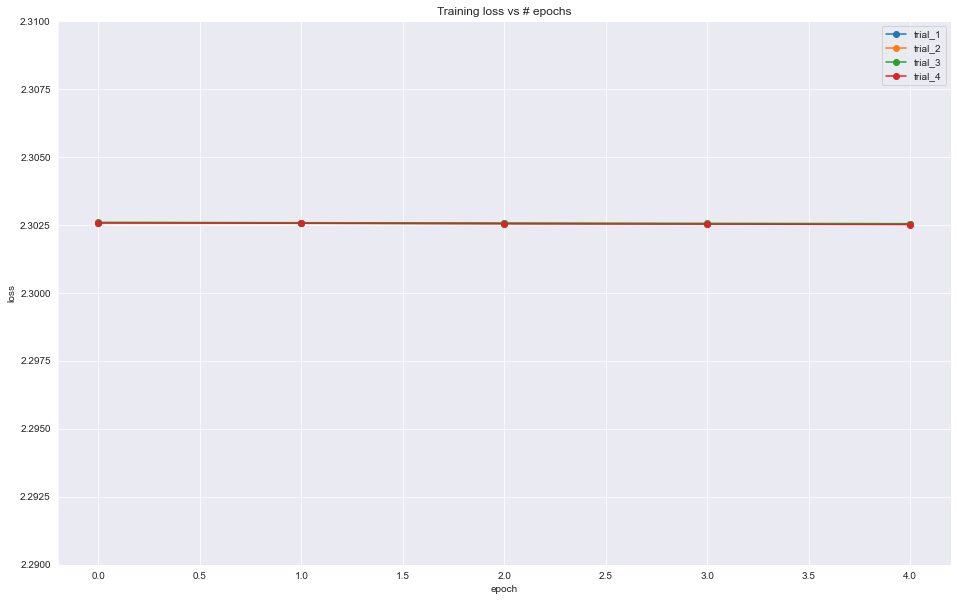

In [46]:
plt.figure(figsize=(16,10))
plt.title('Training loss vs # epochs')
for idx, df in enumerate(training_dfs):
    plt.plot(range(len(df)), df.loss.values, marker='o', label='trial_{}'.format(idx + 1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(2.29, 2.31)
plt.show()

In [47]:
validation_dfs = [pd.DataFrame(r['validation']) for r in res]
validation_df = pd.concat(validation_dfs, axis=0, ignore_index=False)
validation_df.loc[:, 'epoch'] = training_df.index
validation_df.head(n=6)

,loss,likelihood,accuracy,log,epoch
0,tensor(2.3026),tensor(0.1000),tensor(0.0858),"{'validation/loss': tensor(2.3026), 'validatio...",0
1,tensor(2.3026),tensor(0.1000),tensor(0.0954),"{'validation/loss': tensor(2.3026), 'validatio...",1
2,tensor(2.3025),tensor(0.1000),tensor(0.1063),"{'validation/loss': tensor(2.3025), 'validatio...",2
3,tensor(2.3025),tensor(0.1000),tensor(0.1197),"{'validation/loss': tensor(2.3025), 'validatio...",3
4,tensor(2.3025),tensor(0.1000),tensor(0.1334),"{'validation/loss': tensor(2.3025), 'validatio...",4
0,tensor(2.3026),tensor(0.1000),tensor(0.0966),"{'validation/loss': tensor(2.3026), 'validatio...",0


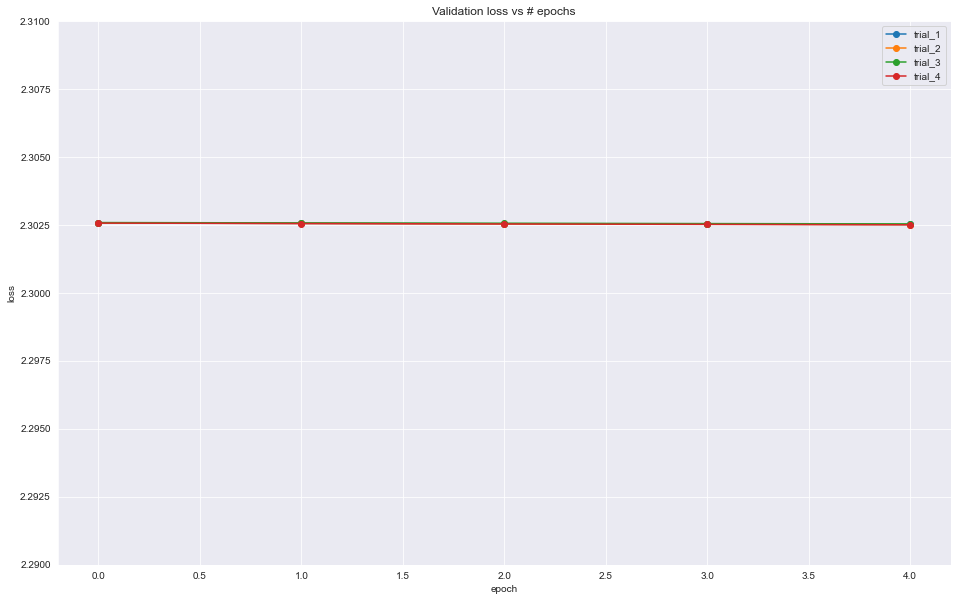

In [50]:
plt.figure(figsize=(16,10))
plt.title('Validation loss vs # epochs')
for idx, df in enumerate(validation_dfs):
    plt.plot(range(len(df)), df.loss.values, marker='o', label='trial_{}'.format(idx + 1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(2.29, 2.31)  
plt.show()

In [18]:
res[0]['training']

[{'loss': 2.3025835,
  'likelihood': 0.10000014,
  'accuracy': 0.081,
  'pred_proba': 0.1000307},
 {'loss': 2.3025703,
  'likelihood': 0.10000148,
  'accuracy': 0.0904375,
  'pred_proba': 0.10003027},
 {'loss': 2.3025572,
  'likelihood': 0.10000281,
  'accuracy': 0.1008125,
  'pred_proba': 0.100029886},
 {'loss': 2.3025439,
  'likelihood': 0.10000413,
  'accuracy': 0.11225,
  'pred_proba': 0.100029625},
 {'loss': 2.3025305,
  'likelihood': 0.10000547,
  'accuracy': 0.12541667,
  'pred_proba': 0.10002944}]

In [19]:
res[0]['validation']

[{'loss': tensor(2.3026),
  'likelihood': tensor(0.1000),
  'accuracy': tensor(0.0858),
  'log': {'validation/loss': tensor(2.3026),
   'validation/likelihood': tensor(0.1000),
   'validation/avg_accuracy': tensor(0.0861),
   'validation/accuracy': tensor(0.0858)}},
 {'loss': tensor(2.3026),
  'likelihood': tensor(0.1000),
  'accuracy': tensor(0.0954),
  'log': {'validation/loss': tensor(2.3026),
   'validation/likelihood': tensor(0.1000),
   'validation/avg_accuracy': tensor(0.0957),
   'validation/accuracy': tensor(0.0954)}},
 {'loss': tensor(2.3025),
  'likelihood': tensor(0.1000),
  'accuracy': tensor(0.1063),
  'log': {'validation/loss': tensor(2.3025),
   'validation/likelihood': tensor(0.1000),
   'validation/avg_accuracy': tensor(0.1066),
   'validation/accuracy': tensor(0.1063)}},
 {'loss': tensor(2.3025),
  'likelihood': tensor(0.1000),
  'accuracy': tensor(0.1197),
  'log': {'validation/loss': tensor(2.3025),
   'validation/likelihood': tensor(0.1000),
   'validation/avg_acc